In [1]:
import copy
import time
import tqdm
import warnings
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T

from google.colab import files
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR100
from torchvision.models import resnet18
from torchsummary import summary

warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
seed = 10
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [3]:
resnet = resnet18(pretrained=True)
resnet.fc = nn.Identity()

for params in resnet.parameters():
    params.requires_grad = False

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

device_count = torch.cuda.device_count()
torch.backends.cudnn.benchmark = True

normal_input_shape = (3, 32, 32)
pre_trained_input_shape = (3, 224, 224)
batch_size = 200
epochs = 10
normal_learning_rate = 0.001
transfer_learning_rate = 0.001
momentum = 0.9

print("Device :", device)
print("GPU Count :", device_count)

Device : cuda
GPU Count : 1


In [5]:
def get_data_loaders(validation_split=0.1, model_type='normal'):
    if model_type == 'pretrained':
        mean=[0.485, 0.456, 0.406]
        std=[0.229, 0.224, 0.225]
    else:
        mean = [0.5071, 0.4867, 0.4408]
        std = [0.2675, 0.2565, 0.2761]
    
    transform =  T.Compose(
        [
            T.Resize(size=(224 if model_type == 'pretrained' else 32)),
            T.ToTensor(),
            T.Normalize(mean, std)
        ]
    )

    data_set = {}

    data = CIFAR100(root="./data/train",train=True, download=True, transform=transform)
    data_set['test'] = CIFAR100(root="./data/test", train=False, download=True, transform=transform)

    val_len = int(len(data)*validation_split)

    data_set['validation'], data_set['train'] = torch.utils.data.random_split(data, [val_len, len(data)-val_len])
    
    print()
    print("Train data length", len(data_set['train']))
    print("Valiation data length", len(data_set['validation']))
    print("Test data length", len(data_set['test']))
    print()

    data_loader = dict(
        [
        (k, DataLoader(dataset=v, batch_size=batch_size, shuffle=(k == 'train'), pin_memory=True, num_workers=4*device_count, drop_last=True))
        for k, v in data_set.items() 
        ]
    )
    
    return data_loader

In [6]:
# !rm -rf ./data

normal_data_loader = get_data_loaders(validation_split=0.1, model_type='normal')
transfered_data_loader = get_data_loaders(validation_split=0.1, model_type='pretrained')

Files already downloaded and verified
Files already downloaded and verified

Train data length 45000
Valiation data length 5000
Test data length 10000

Files already downloaded and verified
Files already downloaded and verified

Train data length 45000
Valiation data length 5000
Test data length 10000



In [7]:
class Net(nn.Module):
    def __init__(self, pre_trained=None):
        super(Net, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=16),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=32),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=64),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=128),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(128, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=512),
            nn.MaxPool2d(2, 2),

            nn.Flatten(),
        )
        self.pre_trained = nn.Identity() if pre_trained == None else pre_trained
        self.fc = nn.Sequential(
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=256, out_features=100),
        )
        

    def forward(self, x):
        if isinstance(self.pre_trained, nn.Identity):
            x = self.conv_layers(x)
        else:
            x = self.pre_trained(x)
        
        x = self.fc(x)
        return x

In [8]:
net = Net().to(device)
print("Normal Conv Net :")
summary(model=net, input_size=normal_input_shape, batch_size=batch_size, device=device)

Normal Conv Net :
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [200, 16, 32, 32]             448
              ReLU-2          [200, 16, 32, 32]               0
       BatchNorm2d-3          [200, 16, 32, 32]              32
         MaxPool2d-4          [200, 16, 16, 16]               0
            Conv2d-5          [200, 32, 16, 16]           4,640
              ReLU-6          [200, 32, 16, 16]               0
       BatchNorm2d-7          [200, 32, 16, 16]              64
         MaxPool2d-8            [200, 32, 8, 8]               0
            Conv2d-9            [200, 64, 8, 8]          18,496
             ReLU-10            [200, 64, 8, 8]               0
      BatchNorm2d-11            [200, 64, 8, 8]             128
        MaxPool2d-12            [200, 64, 4, 4]               0
           Conv2d-13           [200, 128, 4, 4]          73,856
             ReLU-14 

In [9]:
transfer_net = Net(pre_trained=resnet).to(device)
print("ResNet Transfer Net :")
summary(model=transfer_net, input_size=pre_trained_input_shape, batch_size=batch_size, device=device)

ResNet Transfer Net :
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [200, 64, 112, 112]           9,408
       BatchNorm2d-2        [200, 64, 112, 112]             128
              ReLU-3        [200, 64, 112, 112]               0
         MaxPool2d-4          [200, 64, 56, 56]               0
            Conv2d-5          [200, 64, 56, 56]          36,864
       BatchNorm2d-6          [200, 64, 56, 56]             128
              ReLU-7          [200, 64, 56, 56]               0
            Conv2d-8          [200, 64, 56, 56]          36,864
       BatchNorm2d-9          [200, 64, 56, 56]             128
             ReLU-10          [200, 64, 56, 56]               0
       BasicBlock-11          [200, 64, 56, 56]               0
           Conv2d-12          [200, 64, 56, 56]          36,864
      BatchNorm2d-13          [200, 64, 56, 56]             128
             ReLU

In [23]:
def model_train(model, criterion, optimizer, data_loader, epochs,
                epochs_to_watch = -1, accuracy_min_diff = 0.001, max_val_acc_needed = None):
    history = {
        'epochs' : 0,
        'train' : {
            'losses' : [],
            'accuracies' : [],
            'total_loss' : 0,
            'total_acc' : 0
        },
        'validation' : {
            'losses' : [],
            'accuracies' : [],
            'total_loss' : 0,
            'total_acc' : 0
        }
    }
    
    best_state_dict = copy.deepcopy(model.state_dict())
    best_val_acc = -float('inf')
    epochs_no_improve = 0
    width = len(str(epochs))

    train_start = time.time()
    # =============================================

    for e in range(1, epochs+1):
        try:
            epoch_start = time.time()
            total_loss = 0
            total_acc = 0
            
            # ===============================================
            for phase in ['train', 'validation']:

                loader = data_loader[phase]

                model.train(phase == 'train')
                with torch.set_grad_enabled(phase == 'train'):
                    for images, labels in tqdm.notebook.tqdm(loader, leave=False, desc=f"{phase.capitalize()} Epoch"):
                        # shift data to device
                        images, labels =  images.to(device), labels.to(device)
                        
                        # clear gradients
                        optimizer.zero_grad()

                        # get the output and calculate loss
                        output = model(images)
                        loss = criterion(output, labels)

                        if phase == 'train':
                            # adjust the variables
                            loss.backward()
                            optimizer.step()

                        # calculate accuracy and add to total accuracy
                        _ , pred = torch.max(output.data, 1)
                        history[phase]['total_acc'] += (labels == pred).sum().item()

                        # add loss
                        history[phase]['total_loss'] += (loss.item() * loader.batch_size)
            
                    # calculate average loss and accuracy
                    history[phase]['total_loss'] /= len(loader.dataset)
                    history[phase]['total_acc']  /= len(loader.dataset)

                    # append losses and accuracies
                    history[phase]['losses'].append(history[phase]['total_loss'])
                    history[phase]['accuracies'].append(history[phase]['total_acc'])

            # ===============================================
            
            epoch_end = time.time()
            
            history['epochs'] += 1

            print(f"Epoch[{e:0{width}}/{epochs}] ::", end=" ")
            print(f"Train (Loss = {history['train']['total_loss'] : .4f}, Acc = {history['train']['total_acc'] : .4f}),", end=" ")
            print(f"Validation (Loss = {history['validation']['total_loss'] : .4f}, Acc = {history['validation']['total_acc'] : .4f}),", end=" ")
            print(f"Epoch Time = {epoch_end - epoch_start : .2f}s, Total Time = {epoch_end - train_start : .2f}s")

            if best_val_acc < history['validation']['total_acc']:
                best_state_dict = copy.deepcopy(model.state_dict())
            
            if history['validation']['total_acc'] - best_val_acc >= accuracy_min_diff:
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve == epochs_to_watch:
                    print(f"No validation accuracy improvement for {epochs_to_watch} epochs. Early Stopping!!")
                    break
            
            best_val_acc = max(best_val_acc, history['validation']['total_acc'])

            if max_val_acc_needed != None and best_val_acc >= max_val_acc_needed:
                print(f"Validation Accuracy : {best_val_acc}, Specified maximum accuracy achieved. Stopping!!")
                break
            
        except KeyboardInterrupt:
            print("Keyboard interrupt occured. Stopping!!")
            break

    # =============================================
    train_end = time.time()

    print(f"\nTotal Training Time : {train_end - train_start : .2f}s")

    # get best model
    model.load_state_dict(best_state_dict)

    # remove unnecessary keys
    for phase in ['train', 'validation']:
        history[phase].pop('total_loss', None)
        history[phase].pop('total_acc', None)
    
    return model, history

In [11]:
def model_test(model, criterion, test_loader):
    model.eval()
    with torch.no_grad():
        total_test_acc = 0
        total_test_loss = 0
        
        test_start = time.time()

        for images, labels in tqdm.notebook.tqdm(test_loader, leave=False, desc="Testing Epoch"):
            # shift data to device
            images, labels = images.to(device), labels.to(device)

            # get the output and loss
            output = model(images)
            loss = criterion(output, labels)

            # calculate test accuracy and loss
            _ , pred = torch.max(output.data, 1)
            total_test_acc += (labels == pred).sum().item()
            total_test_loss += (loss.item() * test_loader.batch_size)
        
        test_end = time.time()

        print(f"Test time : {test_end - test_start : .2f}s")
        print(f"Test Loss : {total_test_loss/len(test_loader.dataset) : .4f}")
        print(f"Test Accuracy : {total_test_acc/len(test_loader.dataset) : .4f}")

In [12]:
def plot_history(history, suptitle):
    fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(20,5))

    fig.suptitle(suptitle)

    loss_ax.plot(range(1, history['epochs']+1), history['train']['losses'], label="Training Loss", marker='x')
    loss_ax.plot(range(1, history['epochs']+1), history['validation']['losses'], label="Validation Loss", marker='x')
    loss_ax.set_title("Training and Validation Losses")
    loss_ax.set_xlabel("Epochs")
    loss_ax.set_ylabel("Losses")
    loss_ax.legend()

    acc_ax.plot(range(1, history['epochs']+1), history['train']['accuracies'], label="Training Acc", marker='x')
    acc_ax.plot(range(1, history['epochs']+1), history['validation']['accuracies'], label="Validation Acc", marker='x')
    acc_ax.set_title("Training and Validation Accuracies")
    acc_ax.set_xlabel("Epochs")
    acc_ax.set_ylabel("Accuracies")
    acc_ax.legend()

    plt.show()

In [13]:
criterion = nn.CrossEntropyLoss().to(device)
normal_optimizer = optim.SGD(net.parameters(), lr=normal_learning_rate, momentum=momentum)
transfer_optimizer = optim.SGD(transfer_net.parameters(), lr=transfer_learning_rate, momentum=momentum)

In [14]:
best_normal_model, normal_model_history = model_train(
    model=net, criterion=criterion,
    optimizer=normal_optimizer, data_loader=normal_data_loader,
    epochs=epochs
)

Epoch[01/10] :: Train (Loss =  4.2779, Acc =  0.0716), Validation (Loss =  3.9585, Acc =  0.1214), Epoch Time =  10.16s, Total Time =  10.16s


Epoch[02/10] :: Train (Loss =  3.7085, Acc =  0.1537), Validation (Loss =  3.5525, Acc =  0.1742), Epoch Time =  10.20s, Total Time =  20.37s


Epoch[03/10] :: Train (Loss =  3.3500, Acc =  0.2105), Validation (Loss =  3.2763, Acc =  0.2154), Epoch Time =  10.62s, Total Time =  31.01s


Epoch[04/10] :: Train (Loss =  3.0647, Acc =  0.2595), Validation (Loss =  3.0671, Acc =  0.2532), Epoch Time =  10.64s, Total Time =  41.65s


Epoch[05/10] :: Train (Loss =  2.8305, Acc =  0.3012), Validation (Loss =  2.9089, Acc =  0.2777), Epoch Time =  10.44s, Total Time =  52.10s


Epoch[06/10] :: Train (Loss =  2.6269, Acc =  0.3422), Validation (Loss =  2.7786, Acc =  0.2987), Epoch Time =  10.48s, Total Time =  62.58s


Epoch[07/10] :: Train (Loss =  2.4521, Acc =  0.3763), Validation (Loss =  2.7027, Acc =  0.3143), Epoch Time =  10.58s, Total Time =  73.17s


Epoch[08/10] :: Train (Loss =  2.2929, Acc =  0.4128), Validation (Loss =  2.6370, Acc =  0.3291), Epoch Time =  10.46s, Total Time =  83.64s


Epoch[09/10] :: Train (Loss =  2.1437, Acc =  0.4461), Validation (Loss =  2.5712, Acc =  0.3451), Epoch Time =  10.67s, Total Time =  94.31s


Epoch[10/10] :: Train (Loss =  2.0016, Acc =  0.4813), Validation (Loss =  2.5209, Acc =  0.3547), Epoch Time =  10.22s, Total Time =  104.55s

Total Training Time :  104.55s


In [15]:
best_transfer_model, transfer_model_history = model_train(
    model=transfer_net, criterion=criterion,
    optimizer=transfer_optimizer, data_loader=transfered_data_loader,
    epochs=epochs
)

Epoch[01/10] :: Train (Loss =  4.5452, Acc =  0.0334), Validation (Loss =  4.4446, Acc =  0.0702), Epoch Time =  84.26s, Total Time =  84.26s


Epoch[02/10] :: Train (Loss =  4.3100, Acc =  0.1293), Validation (Loss =  4.1496, Acc =  0.1948), Epoch Time =  83.88s, Total Time =  168.16s


Epoch[03/10] :: Train (Loss =  3.9483, Acc =  0.2306), Validation (Loss =  3.7325, Acc =  0.2838), Epoch Time =  83.98s, Total Time =  252.15s


Epoch[04/10] :: Train (Loss =  3.5087, Acc =  0.3017), Validation (Loss =  3.3016, Acc =  0.3239), Epoch Time =  84.31s, Total Time =  336.48s


Epoch[05/10] :: Train (Loss =  3.1097, Acc =  0.3535), Validation (Loss =  2.9504, Acc =  0.3747), Epoch Time =  84.72s, Total Time =  421.21s


Epoch[06/10] :: Train (Loss =  2.7988, Acc =  0.3930), Validation (Loss =  2.6909, Acc =  0.4123), Epoch Time =  83.81s, Total Time =  505.03s


Epoch[07/10] :: Train (Loss =  2.5652, Acc =  0.4206), Validation (Loss =  2.4958, Acc =  0.4279), Epoch Time =  84.38s, Total Time =  589.42s


Epoch[08/10] :: Train (Loss =  2.3894, Acc =  0.4435), Validation (Loss =  2.3382, Acc =  0.4483), Epoch Time =  84.38s, Total Time =  673.81s


Epoch[09/10] :: Train (Loss =  2.2507, Acc =  0.4582), Validation (Loss =  2.2203, Acc =  0.4643), Epoch Time =  85.00s, Total Time =  758.83s


Epoch[10/10] :: Train (Loss =  2.1419, Acc =  0.4744), Validation (Loss =  2.1292, Acc =  0.4733), Epoch Time =  84.82s, Total Time =  843.67s

Total Training Time :  843.69s


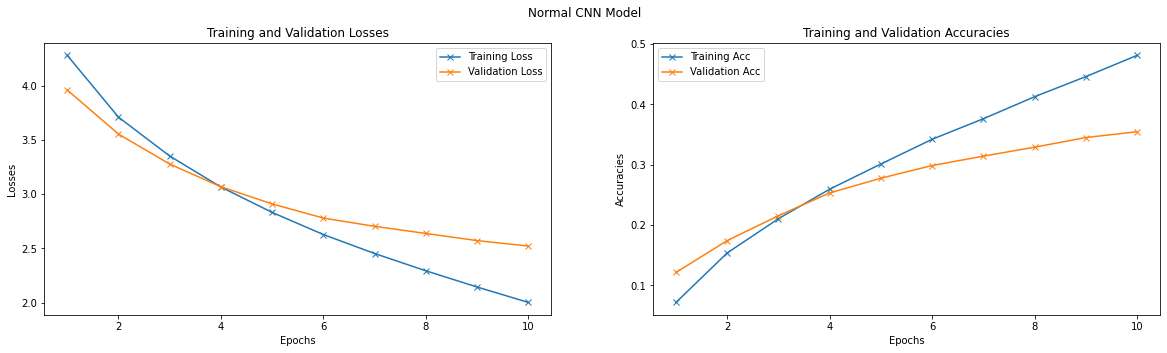

In [16]:
plot_history(normal_model_history, "Normal CNN Model")

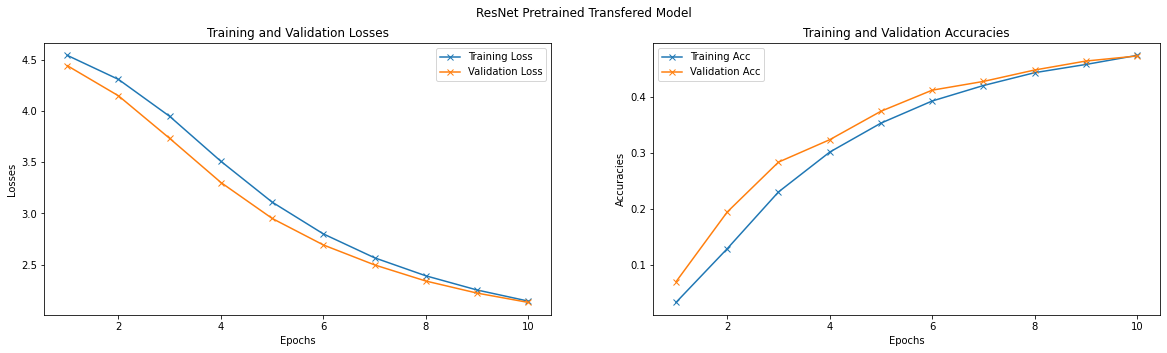

In [17]:
plot_history(transfer_model_history, "ResNet Pretrained Transfered Model")

In [18]:
model_test(model=best_normal_model, criterion=criterion, test_loader=normal_data_loader['test'])

Test time :  2.13s
Test Loss :  2.5139
Test Accuracy :  0.3610


In [19]:
model_test(model=best_transfer_model, criterion=criterion, test_loader=transfered_data_loader['test'])

Test time :  17.52s
Test Loss :  2.1267
Test Accuracy :  0.4735


In [24]:
_net = Net().to(device)
_normal_optimizer = optim.SGD(_net.parameters(), lr=normal_learning_rate, momentum=momentum)

print("New Conv Net :")
summary(model=_net, input_size=normal_input_shape, batch_size=batch_size, device=device)

New Conv Net :
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [200, 16, 32, 32]             448
              ReLU-2          [200, 16, 32, 32]               0
       BatchNorm2d-3          [200, 16, 32, 32]              32
         MaxPool2d-4          [200, 16, 16, 16]               0
            Conv2d-5          [200, 32, 16, 16]           4,640
              ReLU-6          [200, 32, 16, 16]               0
       BatchNorm2d-7          [200, 32, 16, 16]              64
         MaxPool2d-8            [200, 32, 8, 8]               0
            Conv2d-9            [200, 64, 8, 8]          18,496
             ReLU-10            [200, 64, 8, 8]               0
      BatchNorm2d-11            [200, 64, 8, 8]             128
        MaxPool2d-12            [200, 64, 4, 4]               0
           Conv2d-13           [200, 128, 4, 4]          73,856
             ReLU-14    

In [25]:
_best_normal_model, _normal_model_history = model_train(
    model=_net, criterion=criterion,
    optimizer=_normal_optimizer, data_loader=normal_data_loader,
    epochs=100, epochs_to_watch=5, accuracy_min_diff = 0.001,
    max_val_acc_needed=max(transfer_model_history['validation']['accuracies'])
)

Epoch[001/100] :: Train (Loss =  4.2901, Acc =  0.0687), Validation (Loss =  3.9705, Acc =  0.1206), Epoch Time =  10.59s, Total Time =  10.59s


Epoch[002/100] :: Train (Loss =  3.7031, Acc =  0.1566), Validation (Loss =  3.5457, Acc =  0.1790), Epoch Time =  10.14s, Total Time =  20.74s


Epoch[003/100] :: Train (Loss =  3.3186, Acc =  0.2162), Validation (Loss =  3.2630, Acc =  0.2190), Epoch Time =  11.01s, Total Time =  31.76s


Epoch[004/100] :: Train (Loss =  3.0308, Acc =  0.2646), Validation (Loss =  3.0466, Acc =  0.2468), Epoch Time =  10.72s, Total Time =  42.49s


Epoch[005/100] :: Train (Loss =  2.8037, Acc =  0.3066), Validation (Loss =  2.8936, Acc =  0.2798), Epoch Time =  10.37s, Total Time =  52.88s


Epoch[006/100] :: Train (Loss =  2.6111, Acc =  0.3459), Validation (Loss =  2.7834, Acc =  0.2969), Epoch Time =  10.42s, Total Time =  63.31s


Epoch[007/100] :: Train (Loss =  2.4323, Acc =  0.3818), Validation (Loss =  2.7061, Acc =  0.3087), Epoch Time =  10.37s, Total Time =  73.69s


Epoch[008/100] :: Train (Loss =  2.2875, Acc =  0.4174), Validation (Loss =  2.6483, Acc =  0.3211), Epoch Time =  10.60s, Total Time =  84.30s


Epoch[009/100] :: Train (Loss =  2.1424, Acc =  0.4483), Validation (Loss =  2.5915, Acc =  0.3457), Epoch Time =  10.56s, Total Time =  94.86s


Epoch[010/100] :: Train (Loss =  2.0052, Acc =  0.4819), Validation (Loss =  2.5509, Acc =  0.3451), Epoch Time =  10.23s, Total Time =  105.11s


Epoch[011/100] :: Train (Loss =  1.8731, Acc =  0.5113), Validation (Loss =  2.5300, Acc =  0.3505), Epoch Time =  10.36s, Total Time =  115.47s


Epoch[012/100] :: Train (Loss =  1.7490, Acc =  0.5442), Validation (Loss =  2.5063, Acc =  0.3631), Epoch Time =  10.67s, Total Time =  126.14s


Epoch[013/100] :: Train (Loss =  1.6047, Acc =  0.5826), Validation (Loss =  2.5105, Acc =  0.3743), Epoch Time =  10.88s, Total Time =  137.02s


Epoch[014/100] :: Train (Loss =  1.4791, Acc =  0.6158), Validation (Loss =  2.5250, Acc =  0.3649), Epoch Time =  10.18s, Total Time =  147.21s


Epoch[015/100] :: Train (Loss =  1.3545, Acc =  0.6499), Validation (Loss =  2.5373, Acc =  0.3667), Epoch Time =  10.16s, Total Time =  157.38s


Epoch[016/100] :: Train (Loss =  1.2339, Acc =  0.6827), Validation (Loss =  2.5710, Acc =  0.3617), Epoch Time =  10.53s, Total Time =  167.90s


Epoch[017/100] :: Train (Loss =  1.1067, Acc =  0.7200), Validation (Loss =  2.5976, Acc =  0.3617), Epoch Time =  10.73s, Total Time =  178.64s


Epoch[018/100] :: Train (Loss =  0.9899, Acc =  0.7551), Validation (Loss =  2.6589, Acc =  0.3665), Epoch Time =  10.26s, Total Time =  188.89s
No validation accuracy improvement for 5 epochs. Early Stopping!!

Total Training Time :  188.90s


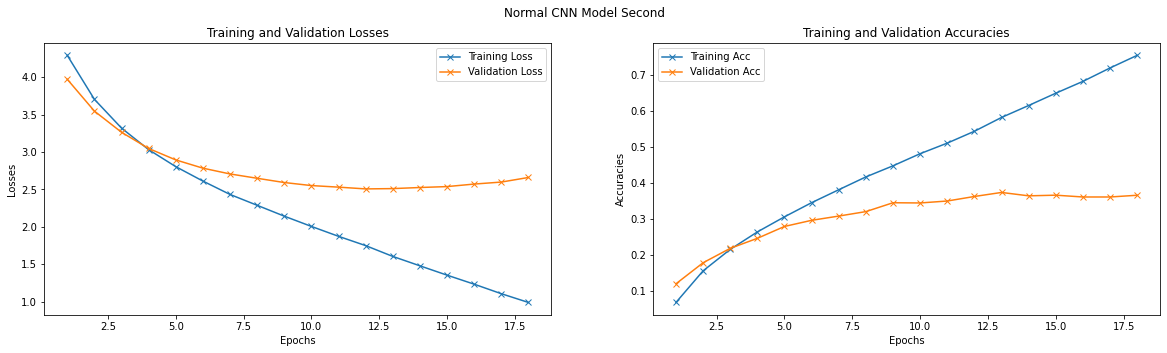

In [26]:
plot_history(_normal_model_history, "Normal CNN Model Second")

In [27]:
model_test(model=_best_normal_model, criterion=criterion, test_loader=normal_data_loader['test'])

Test time :  2.13s
Test Loss :  2.5175
Test Accuracy :  0.3640


In [28]:
torch.save(best_normal_model, 'normal_cnn.pth')
torch.save(best_transfer_model, 'resnet_transfered.pth')
torch.save(_best_normal_model, '_normal_cnn.pth')

In [30]:
files.download('normal_cnn.pth')
files.download('resnet_transfered.pth')
files.download('_normal_cnn.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>